In [1]:
import os
import glob

import DESutils
import GPRutils
import vK2KGPR
import plotGPR
import vK2KGPR
import vonkarmanFT as vk

import numpy as np
import astropy.units as u
import astropy.table as tb
from astropy.time import Time
import matplotlib.pyplot as plt
plt.style.use('~/GitHub/custom-matplotlib/custom.mplstyle')
import astropy.stats as stats
from scipy.signal import savgol_filter
import scipy.linalg
import astropy.coordinates as co

from IPython import embed
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
eris_true_FITS = "/home/fortino/DESworkspace/data/eris_true.fits"
eris_true = tb.Table.read(eris_true_FITS)
eris_true_exps = np.array(np.unique(eris_true["EXPNUM"]), dtype=int)

eris_true.show_in_notebook()

idx,RA,DEC,XWIN_IMAGE,YWIN_IMAGE,MAG,EXPNUM,CCDNUM,MJD_OBS,BAND,ERRAWIN_WORLD
0,25.65413205351103,-3.40369364645907,591.9478759765625,2819.55908203125,19.07012446181116,233221,20,56547.394167077575,g,1.1026299944205675e-06
1,25.62471712930943,-3.4179971299815404,871.7701416015625,2369.59765625,18.231247130042036,234928,20,56551.32631116093,Y,8.587099728174508e-06
2,25.483054040778136,-3.478566444377312,1998.750732421875,958.8739013671875,19.041695125411145,240777,11,56568.29969905758,g,8.452910265077662e-07
3,25.475024574644998,-3.4816644110749575,1765.834228515625,297.6802062988281,19.048625591842956,241125,20,56569.200296217576,g,7.076520205373527e-07
4,25.27225333467316,-3.5488797101605014,1702.16064453125,1757.9273681640625,19.061330059369364,246881,41,56591.14532113758,g,1.012070015349309e-06
5,24.887509525960837,-3.600089808370126,112.17938995361328,841.9015502929688,18.60667313117216,264536,46,56641.13384800092,Y,3.3572600841580424e-06
6,25.620745472110503,-3.2141408246268037,1595.6358642578125,163.58465576171875,18.51011390465698,364725,29,56932.33411606758,r,5.119150046084542e-07
7,25.620733683362506,-3.2141461477604727,1675.17041015625,3377.41650390625,19.031272287740336,364726,56,56932.33547958758,g,1.1501799690449843e-06
8,25.62072628119369,-3.21415320466121,1591.363525390625,175.46981811523438,18.406556151539682,364727,29,56932.33683486757,i,7.388459835055983e-07
9,25.32673489691202,-3.30772339866268,362.2659606933594,1941.66796875,18.642458804327276,374544,31,56964.241318330925,Y,2.667740091055748e-06


In [3]:
def getXiStuff(dC, rMax):
    xi1, xi2 = dC.JackKnifeXi(rMax=rMax)
    xi0_raw, xi0_GPR = np.abs(xi1[0].value), np.abs(xi2[0].value)
    
    xi1, xi2 = dC.JackKnifeXi(rMax=rMax, fC=True)
    _, xi0_fit = np.abs(xi1[0].value), np.abs(xi2[0].value)
    
    return xi0_raw, xi0_fit, xi0_GPR

In [4]:
def getErisStuff(dC, RA_ERIS, DEC_ERIS, tol=0.5*u.arcsec, plot=False):
    
    # Load a new dataContainer object hat has NEW RA and NEW DEC columns in
    # the Pred and TV tables. The current Pred and TV tables in the current FITS files
    # don't have these columns.
    dataC = GPRutils.dataContainer()
    dataC.load(expNum, useRMS=dC.useRMS)
    
    # Find the row for Eris in the prediction table. It will likely be in the prediction dataset, not the TV
    # dataset because it is so dim and therefore won't have a Gaia match. Match the RA and Dec for Eris to the
    # prediction dataset and find a match within tol.
    X_DES = co.SkyCoord(dataC.Pred["NEW RA"], dataC.Pred["NEW DEC"])
    X_ERIS = co.SkyCoord([RA_ERIS*u.deg], [DEC_ERIS*u.deg])
    idx, sep2d, dist3d = co.match_coordinates_sky(X_DES, X_ERIS)
    ind_ERIS = np.where(sep2d < tol)[0]
    
    # Ensure that there is only one match within tol.
    if len(ind_ERIS) > 1:
        print(f"##### {len(ind_ERIS)} matches within {tol} for exposure {expNum}. #####---------------")
        print(dataC.Pred[ind_ERIS])
        ind_ERIS = [ind_ERIS[0]]
    
    # Now that we know the index of the row in the Prediction table that corresponds to Eris,
    # Take the X and Y data (gnomonic projection of RA and Dec, respectively), and format them
    # For the linear algebra below.
    row = dataC.Pred[ind_ERIS]
    X_ERIS = np.vstack([[row["X"]], [row["Y"]]]).T
    
    
    if plot:
        # Proof that the position from eris_true.fits is properly matched in the Prediction dataset.
        print()
        plt.scatter(dataC.Pred["NEW RA"], dataC.Pred["NEW DEC"], c="tab:blue", marker=".")  # Plot the whole prediction dataset.
        plt.scatter(RA_ERIS, DEC_ERIS, c="tab:red", marker="x")  # Plot the RA and Dec of Eris from eris_true.fits
        plt.scatter(dataC.Pred["NEW RA"][ind_ERIS], dataC.Pred["NEW DEC"][ind_ERIS], c="tab:green", marker="+")  # Plot the RA and Dec of Eris from the Prediction dataset.
        arcsec = (1*u.arcsec).to(u.deg).value
        plt.xlim((RA_ERIS-arcsec, RA_ERIS+arcsec))
        plt.ylim((DEC_ERIS-arcsec, DEC_ERIS+arcsec))
        plt.show()
        return

    
    # Initialize the TurbulentLayer object with the final parameters for this exposure.
    ttt = vk.TurbulentLayer(
        variance=dC.params[0],
        outerScale=dC.params[1],
        diameter=dC.params[2],
        wind=(dC.params[3], dC.params[4]))

    # Make K
    du, dv = GPRutils.getGrid(dC.Xtrain, dC.Xtrain)
    C = ttt.getCuv(du, dv)
    n1, n2 = C.shape[0], C.shape[1]
    K = np.swapaxes(C, 1, 2).reshape(2*n1, 2*n2)

    # Make the two White kernels.
    W_GAIA, W_DES = GPRutils.makeW(
        dC.Etrain_GAIA, dC.Etrain_DES,
        useRMS=dC.useRMS, curl=dC.curl)

    # Make Ks
    du, dv = GPRutils.getGrid(X_ERIS, dC.Xtrain)
    Cs = ttt.getCuv(du, dv)
    n1, n2 = Cs.shape[0], Cs.shape[1]
    Ks = np.swapaxes(Cs, 1, 2).reshape(2*n1, 2*n2)

    # Find fbar_s
    cho_factor = scipy.linalg.cho_factor(K + W_GAIA + W_DES)
    alpha = scipy.linalg.cho_solve(cho_factor, GPRutils.flat(dC.Ytrain))
    fbar_s = GPRutils.unflat(np.dot(Ks.T, alpha))

    # Make Kss
    du, dv = GPRutils.getGrid(X_ERIS, X_ERIS)
    Css = ttt.getCuv(du, dv)
    n1, n2 = Css.shape[0], Css.shape[1]
    Kss = np.swapaxes(Css, 1, 2).reshape(2*n1, 2*n2)

    # Find V_s
    cho_factor = scipy.linalg.cho_factor(K + W_GAIA + W_DES)
    v = scipy.linalg.cho_solve(cho_factor, Ks)
    V_s = Kss - np.dot(v.T, v)
    
    # Get xi+(r < 0.02 deg)
    xi0_002_raw, xi0_002_fit, xi0_002_GPR = getXiStuff(dC, 0.02*u.deg)
    # Get xi+(r < 0.5 arcmin)
    xi0_05_raw, xi0_05_fit, xi0_05_GPR = getXiStuff(dC, 0.5*u.arcmin)
    
    return fbar_s, V_s, xi0_002_raw, xi0_002_fit, xi0_002_GPR, xi0_05_raw, xi0_05_fit, xi0_05_GPR

In [6]:
dX = []
dY = []
V = []
raw002 = []
fit002 = []
GPR002 = []
raw05 = []
fit05 = []
GPR05 = []

for expNum in eris_true_exps:
    FITSfile = f"/home/fortino/GPRSolutions/eris/GPR.{expNum}.?RC.fits"
    dC = GPRutils.loadFITS(FITSfile)

    row = eris_true[eris_true["EXPNUM"] == expNum]
    ra = row["RA"].item()
    dec = row["DEC"].item()
    
    fbar_s, V_s, xi0_002_raw, xi0_002_fit, xi0_002_GPR, xi0_05_raw, xi0_05_fit, xi0_05_GPR = getErisStuff(dC, ra, dec)
    
    dX.append(fbar_s[0, 0])
    dY.append(fbar_s[0, 1])
    V.append(V_s)
    
    raw002.append(xi0_002_raw)
    fit002.append(xi0_002_fit)
    GPR002.append(xi0_002_GPR)
    
    raw05.append(xi0_05_raw)
    fit05.append(xi0_05_fit)
    GPR05.append(xi0_05_GPR)

DES Exposure : 233221
DES Passband : g
DES nSources : 70368
INFO: Query finished. [astroquery.utils.tap.core]
Maximum allowed stars is 15000, but
    there were 3853 matches within 0.5 arcsec.
DES Exposure : 234928
DES Passband : Y
DES nSources : 27547
INFO: Query finished. [astroquery.utils.tap.core]
Maximum allowed stars is 15000, but
    there were 3937 matches within 0.5 arcsec.
DES Exposure : 240777
DES Passband : g
DES nSources : 91352
INFO: Query finished. [astroquery.utils.tap.core]
Maximum allowed stars is 15000, but
    there were 3888 matches within 0.5 arcsec.
DES Exposure : 241125
DES Passband : g
DES nSources : 101933
INFO: Query finished. [astroquery.utils.tap.core]
Maximum allowed stars is 15000, but
    there were 3795 matches within 0.5 arcsec.
DES Exposure : 246881
DES Passband : g
DES nSources : 69640
INFO: Query finished. [astroquery.utils.tap.core]
Maximum allowed stars is 15000, but
    there were 3776 matches within 0.5 arcsec.
DES Exposure : 264536
DES Passband

In [12]:
C_dXcosDec = tb.Column(
    data=(dX/np.cos(eris_true["DEC"]*u.deg)).value, unit=u.mas,
    name="dXcosDec",
    description="First component of GP posterior predictive mean, divided by cos(Dec).")
C_dX = tb.Column(
    data=dX, unit=u.mas,
    name="dX",
    description="First component of GP posterior predictive mean.")
C_dY = tb.Column(
    data=dY, unit=u.mas,
    name="dY",
    description="Second component of GP posterior predictive mean.")
C_V = tb.Column(
    data=V, unit=u.mas**2,
    name="V",
    description="2x2 posterior predictive covariance for the posterior predictive mean, (dX, dY).")

C_raw002 = tb.Column(
    data=raw002, unit=u.mas**2,
    name="xi0_002_raw",
    description="All-pairs angle-averaged jackknifed xi+(r < 0.02 deg) for the raw data.")
C_fit002 = tb.Column(
    data=fit002, unit=u.mas**2,
    name="xi0_002_fit",
    description="All-pairs angle-averaged jackknifed xi+(r < 0.02 deg) for the raw data with the fitted model removed.")
C_GPR002 = tb.Column(
    data=GPR002, unit=u.mas**2,
    name="xi0_002_GPR",
    description="All-pairs angle-averaged jackknifed xi+(r < 0.02 deg) for the raw data with the final GPR model removed.")

C_raw05 = tb.Column(
    data=raw05, unit=u.mas**2,
    name="xi0_05_raw",
    description="All-pairs angle-averaged jackknifed xi+(r < 0.5 arcmin) for the raw data.")
C_fit05 = tb.Column(
    data=fit05, unit=u.mas**2,
    name="xi0_05_fit",
    description="All-pairs angle-averaged jackknifed xi+(r < 0.5 arcmin) for the raw data with the fitted model removed.")
C_GPR05 = tb.Column(
    data=GPR05, unit=u.mas**2,
    name="xi0_05_GPR",
    description="All-pairs angle-averaged jackknifed xi+(r < 0.5 arcmin) for the raw data with the final GPR model removed.")

cols = [C_dXcosDec, C_dX, C_dY, C_V, C_raw002, C_fit002, C_GPR002, C_raw05, C_fit05, C_GPR05]

In [13]:
# ERIS_SOLNS = tb.QTable(cols)
# ERIS_SOLNS

In [15]:
eris_true_FITS = "/home/fortino/DESworkspace/data/eris_true.fits"
eris_true = tb.Table.read(eris_true_FITS)
eris_true_exps = np.array(np.unique(eris_true["EXPNUM"]), dtype=int)
eris_true.add_columns(cols)

eris_true.show_in_notebook()
eris_true.info()

<Table length=34>
     name      dtype  shape  unit                                                description                                                
------------- ------- ------ ---- ----------------------------------------------------------------------------------------------------------
           RA float64                                                                                                                       
          DEC float64                                                                                                                       
   XWIN_IMAGE float64                                                                                                                       
   YWIN_IMAGE float64                                                                                                                       
          MAG float64                                                                                                                   

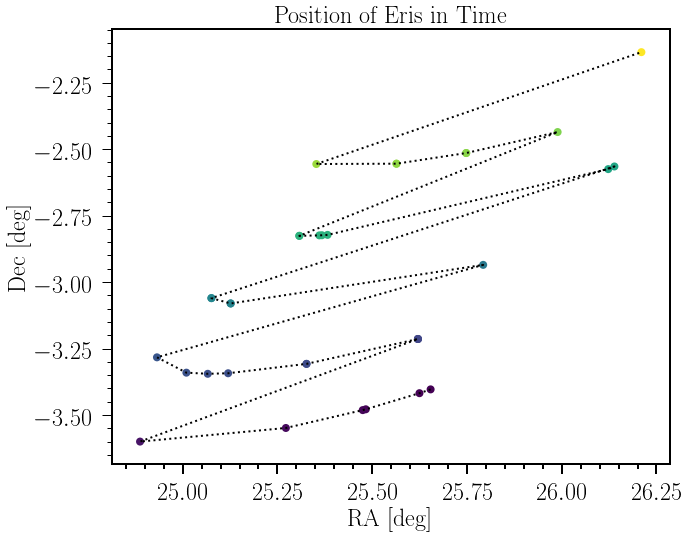

In [16]:
X = np.array(eris_true["RA"])
Y = np.array(eris_true["DEC"])
T = np.array(eris_true["MJD_OBS"])
plt.plot(X, Y, "k:")
plt.scatter(X, Y, c=T, cmap="viridis")

plt.title("Position of Eris in Time")
plt.ylabel("Dec [deg]")
plt.xlabel("RA [deg]")
plt.show()

In [20]:
eris_true.write("/home/fortino/GPRSolutions/GPR.eris.fits", format="fits")